# Analyzing Record/Song Sales Using SQL

Here try to answer some bussniess questions using SQL.

The database schema shows below:

![database schema](Annotation.png)


## Read the database and creat some function for later use

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Identify which genre sold best in USA

In [20]:
q = '''
WITH Sold_in_USA 
AS
(
SELECT li.*
FROM invoice_line li
INNER JOIN invoice i ON i.invoice_id = li.invoice_id
INNER JOIN customer c ON i.customer_id = c.customer_id
WHERE c.country = "USA"
)

SELECT 
g.name genre,
COUNT(siu.invoice_line_id) Track_Sold,
cast(count(siu.invoice_line_id) AS FLOAT) / (
     SELECT COUNT(*) from Sold_in_USA
     ) percentage_sold
FROM Sold_in_USA siu
INNER JOIN track t ON t.track_id = siu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10


'''
run_query(q)


,genre,Track_Sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


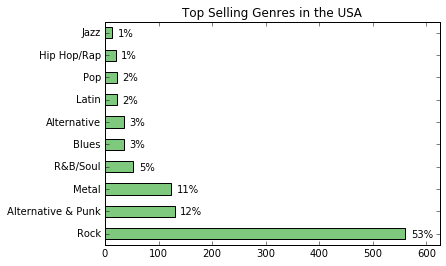

In [27]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["Track_Sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "Track_Sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

## Analyzing Employee Sales Performance

Pull out the total sales each employee made:

In [39]:
q = '''
SELECT e.first_name||" " ||e.last_name Employee,
       sum(i.total)  Total_Sale

FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON c.support_rep_id = e.employee_id

GROUP BY 1
'''

run_query(q)

,Employee,Total_Sale
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


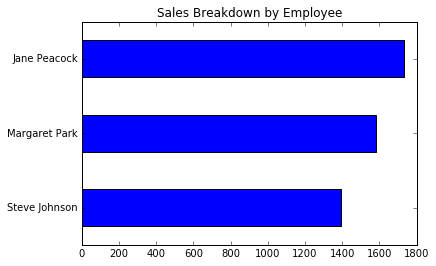

In [44]:
employee_sales = run_query(q)

employee_sales.set_index("Employee", drop=True, inplace=True)
employee_sales.sort_values("Total_Sale", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    
)
plt.ylabel('')
plt.show()

## Analyzing Sales by Country

In [74]:
q = '''

SELECT  
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       
       sum(i.total)  total_sales,
       count(distinct c.customer_id) customers,
       SUM(il.unit_price) / count(distinct i.customer_id) customer_lifetime_value,
       SUM(il.unit_price) / count(distinct i.invoice_id) average_order   
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
INNER JOIN employee e ON c.support_rep_id = e.employee_id

GROUP BY 1
ORDER BY 2 desc
'''

run_query(q)

,country,total_sales,customers,customer_lifetime_value,average_order
0,Other,10808.82,15,72.996000,7.448571
1,USA,10405.89,13,80.037692,7.942672
2,Canada,5489.55,8,66.948750,7.047237
3,Brazil,4059.00,5,85.536000,7.011148
4,France,3972.87,5,77.814000,7.781400
5,Germany,3441.24,4,83.655000,8.161463
6,Czech Republic,3183.84,2,136.620000,9.108000
7,United Kingdom,2498.76,3,81.840000,8.768571
8,India,1887.93,2,91.575000,8.721429
9,Portugal,1755.27,2,92.565000,6.383793


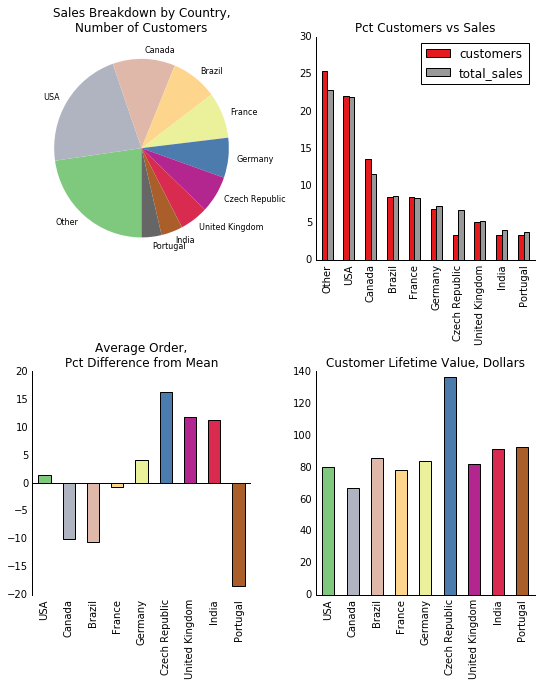

In [75]:
country_metrics = run_query(q)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()